In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/PalmLeavesDataset.zip"

In [4]:
!unzip -o "$zip_path" -d "/content/"

Archive:  /content/drive/MyDrive/PalmLeavesDataset.zip
   creating: /content/PalmLeavesDataset/
   creating: /content/PalmLeavesDataset/Kanchi-University/
   creating: /content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/
   creating: /content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/
   creating: /content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/
   creating: /content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/
  inflating: /content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/kali-output.csv  
   creating: /content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/Kanchi-Na/
  inflating: /content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/Kanchi-Na/output-1.png  
  inflating: /content/PalmLeavesDataset/Kanchi-University/Set1

In [2]:
# First Upload the zip file from the laptop and we will unzip it now :
# !unzip PalmLeavesDataset

Archive:  PalmLeavesDataset.zip
   creating: PalmLeavesDataset/
   creating: PalmLeavesDataset/Kanchi-University/
   creating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/
   creating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/
   creating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/
   creating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/
  inflating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/kali-output.csv  
   creating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/Kanchi-Na/
  inflating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/Kanchi-Na/output-1.png  
  inflating: PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Algorithm-Outputs/2024Mar16/Kanchi-output/Kanchi-Na/output-10.png  
  inflating: PalmLeavesDataset/Kan

# U Net, CNN Model

[INFO] Device: cuda
[Dataset] Found 13 image-mask pairs (target_size=512)
[INFO] Dataset sizes -> total: 13, train: 12, val: 1
Epoch 1/100 - Train Loss: 0.636775  Val Loss: 0.682973
[INFO] Saved best model to /content/artifacts/best_model_20251211_102152.pt
Epoch 2/100 - Train Loss: 0.581719  Val Loss: 0.682529
[INFO] Saved best model to /content/artifacts/best_model_20251211_102155.pt
Epoch 3/100 - Train Loss: 0.540207  Val Loss: 0.681920
[INFO] Saved best model to /content/artifacts/best_model_20251211_102157.pt
Epoch 4/100 - Train Loss: 0.505903  Val Loss: 0.681228
[INFO] Saved best model to /content/artifacts/best_model_20251211_102200.pt
Epoch 5/100 - Train Loss: 0.478087  Val Loss: 0.680333
[INFO] Saved best model to /content/artifacts/best_model_20251211_102204.pt
Epoch 6/100 - Train Loss: 0.454539  Val Loss: 0.679831
[INFO] Saved best model to /content/artifacts/best_model_20251211_102207.pt
Epoch 7/100 - Train Loss: 0.430955  Val Loss: 0.680444
Epoch 8/100 - Train Loss: 0.4110

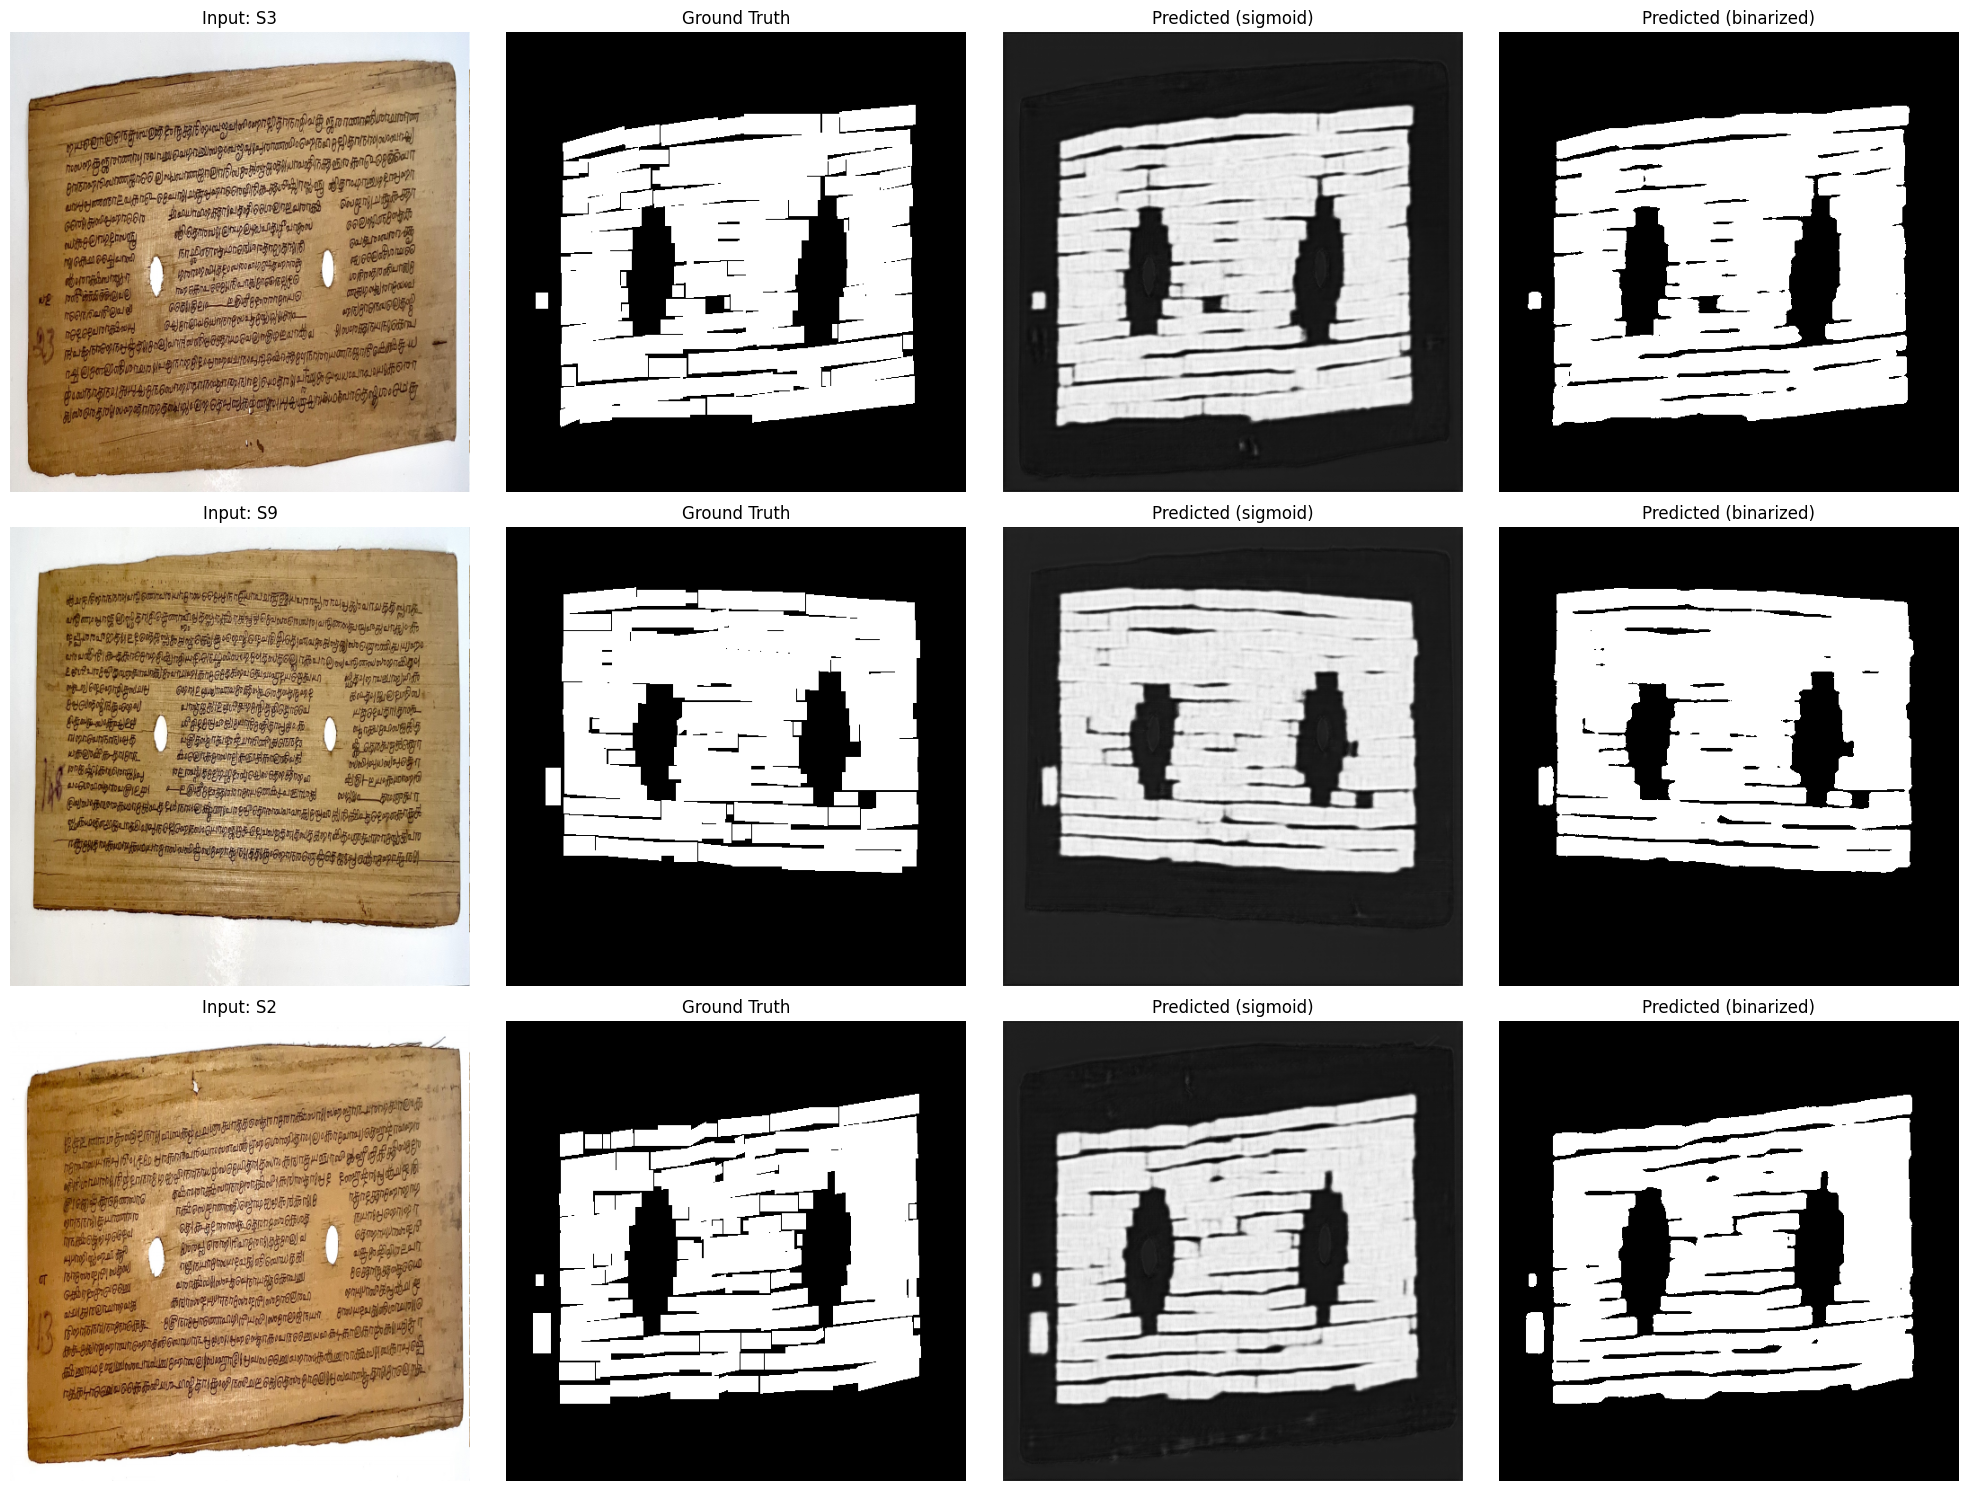

[INFO] Saved visualization to: /content/artifacts/sample_results.png


In [11]:
import os
import cv2
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

# ==================== PATHS ====================
MASK_PATH = "/content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Set1Masks"
INPUT_PATH = "/content/PalmLeavesDataset/Kanchi-University/Set1 15Mar2024/Set1 Original PNG Images"
ARTIFACT_PATH = "/content/artifacts"
os.makedirs(ARTIFACT_PATH, exist_ok=True)


# ==================== MODEL ====================
class SimpleUNet(nn.Module):
    def __init__(self, in_ch=3, base_ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch, 3, padding=1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*2, base_ch*2, 3, padding=1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*4, base_ch*4, 3, padding=1), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True)
        )

        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(base_ch*4, base_ch*8, 3, padding=1), nn.BatchNorm2d(base_ch*8), nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*8, base_ch*8, 3, padding=1), nn.BatchNorm2d(base_ch*8), nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(base_ch*8, base_ch*4, 3, padding=1), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*4, base_ch*4, 3, padding=1), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_ch*4, base_ch*2, 3, padding=1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*2, base_ch*2, 3, padding=1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch, 3, padding=1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch, 3, padding=1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        b  = self.bottleneck(e3)

        u3 = self.up3(b)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        return self.final(d1)


# ==================== DATASET ====================
class PalmDataset(Dataset):
    """
    Pairs images and masks by base filename (safer than naively sorting both directories).
    Masks are converted to binary 0/1 floats to work with BCEWithLogitsLoss.
    Images are converted to RGB and normalized to [0,1].
    """

    def __init__(self, img_dir, mask_dir, target_size=512):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.target_size = int(target_size)

        # collect files
        img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(".png")]
        mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(".png")]

        # create mapping from base -> filename
        img_map = {os.path.splitext(f)[0]: f for f in img_files}
        mask_map = {os.path.splitext(f)[0].replace("_mask",""): f for f in mask_files}

        # intersection of base names
        keys = sorted(set(img_map.keys()) & set(mask_map.keys()))
        if len(keys) == 0:
            raise RuntimeError(f"No matching image-mask pairs found in {img_dir} and {mask_dir}")

        # create paired list of tuples (img_path, mask_path)
        self.pairs = [(os.path.join(img_dir, img_map[k]), os.path.join(mask_dir, mask_map[k]), k) for k in keys]

        # debug
        print(f"[Dataset] Found {len(self.pairs)} image-mask pairs (target_size={self.target_size})")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path, basename = self.pairs[idx]

        # read image and mask
        img = Image.open(img_path)
        # convert grayscale to RGB to keep channels consistent
        if img.mode != "RGB":
            img = img.convert("RGB")
        img_np = np.array(img).astype(np.float32) / 255.0  # H x W x 3

        mask_img = Image.open(mask_path)
        # convert palette/rgba to L
        if mask_img.mode != "L":
            mask_img = mask_img.convert("L")
        mask_np = np.array(mask_img)  # H x W, values typically 0 or 255

        # Resize (cv2 expects W,H)
        H = W = self.target_size
        img_resized = cv2.resize(img_np, (W, H), interpolation=cv2.INTER_AREA)
        mask_resized = cv2.resize(mask_np, (W, H), interpolation=cv2.INTER_NEAREST)

        # Convert mask to binary 0/1 float
        mask_bin = (mask_resized > 127).astype(np.float32)

        # convert to tensors CHW
        img_t = torch.from_numpy(img_resized).permute(2, 0, 1).contiguous()  # (3,H,W)
        mask_t = torch.from_numpy(mask_bin).unsqueeze(0).contiguous()        # (1,H,W)

        return img_t, mask_t, basename


# ==================== TRAINING SETUP ====================
class Args:
    epochs = 100
    batch = 4
    lr = 1e-4
    img_size = 512
    seed = 42
    num_workers = 2

args = Args()
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Device:", device)

dataset = PalmDataset(INPUT_PATH, MASK_PATH, target_size=args.img_size)

n = len(dataset)
val_size = max(1, int(0.1 * n))
train_size = n - val_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size],
                                                 generator=torch.Generator().manual_seed(args.seed))

pin_memory = True if torch.cuda.is_available() else False
train_loader = DataLoader(train_ds, batch_size=args.batch, shuffle=True, num_workers=args.num_workers,
                          pin_memory=pin_memory)
val_loader = DataLoader(val_ds, batch_size=args.batch, shuffle=False, num_workers=args.num_workers,
                        pin_memory=pin_memory)

print(f"[INFO] Dataset sizes -> total: {n}, train: {len(train_ds)}, val: {len(val_ds)}")

model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.BCEWithLogitsLoss()

best_val = float("inf")

# ==================== TRAIN LOOP ====================
for epoch in range(1, args.epochs + 1):
    model.train()
    running_loss = 0.0
    for imgs, masks, _ in train_loader:
        imgs = imgs.to(device, non_blocking=pin_memory)
        masks = masks.to(device, non_blocking=pin_memory)

        preds = model(imgs)               # (B,1,H,W) logits
        preds_s = preds.squeeze(1)        # (B,H,W)
        targets = masks.squeeze(1)        # (B,H,W)

        loss = criterion(preds_s, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for imgs, masks, _ in val_loader:
            imgs = imgs.to(device, non_blocking=pin_memory)
            masks = masks.to(device, non_blocking=pin_memory)

            preds = model(imgs).squeeze(1)
            val_loss = criterion(preds, masks.squeeze(1))
            val_running += val_loss.item() * imgs.size(0)

    val_loss_epoch = val_running / len(val_loader.dataset)

    print(f"Epoch {epoch}/{args.epochs} - Train Loss: {train_loss:.6f}  Val Loss: {val_loss_epoch:.6f}")

    # save best
    if val_loss_epoch < best_val:
        best_val = val_loss_epoch
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        ckpt_path = os.path.join(ARTIFACT_PATH, f"best_model_{ts}.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_loss_epoch
        }, ckpt_path)
        print(f"[INFO] Saved best model to {ckpt_path}")

# final save
final_path = os.path.join(ARTIFACT_PATH, "final_model.pt")
torch.save(model.state_dict(), final_path)
print("[INFO] Training finished. Final model saved to:", final_path)


# ==================== VISUALIZE SAMPLE PREDICTIONS ====================
model.eval()
num_samples = 3
# pick from train_ds (it's a Subset), map indices to underlying dataset
if len(train_ds) < num_samples:
    chosen = list(range(len(train_ds)))
else:
    chosen = random.sample(range(len(train_ds)), num_samples)


plt.figure(figsize=(20, 5 * len(chosen)))
for i, idx in enumerate(chosen):
    img_t, mask_t, name = train_ds[idx]  # train_ds is a Subset returning (img,mask,basename)
    with torch.no_grad():
        pred_logit = model(img_t.unsqueeze(0).to(device))
        pred = torch.sigmoid(pred_logit.cpu()).squeeze().numpy()  # H x W

    binary = (pred > 0.5).astype(np.uint8)
    img_np = img_t.permute(1, 2, 0).numpy()
    mask_np = mask_t.squeeze(0).numpy()

    # input
    plt.subplot(len(chosen), 4, i*4 + 1)
    plt.imshow(img_np)
    plt.title(f"Input: {name}")
    plt.axis("off")

    # ground truth
    plt.subplot(len(chosen), 4, i*4 + 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    # predicted
    plt.subplot(len(chosen), 4, i*4 + 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Predicted (sigmoid)")
    plt.axis("off")

    #binarized
    plt.subplot(len(chosen), 4, i*4 + 4)
    plt.imshow(binary, cmap="gray")
    plt.title("Predicted (binarized)")
    plt.axis("off")

plt.tight_layout()
save_path = os.path.join(ARTIFACT_PATH, "sample_results.png")
plt.savefig(save_path, dpi=150)
plt.show()
print("[INFO] Saved visualization to:", save_path)

### U Net Metrics

In [22]:
import torch
import numpy as np

def compute_metrics(y_pred, y_true, threshold=0.5):
    """
    y_pred, y_true: numpy arrays of shape (H, W) with values in {0,1}
    """
    pred = (y_pred > threshold).astype(np.uint8)
    true = y_true.astype(np.uint8)

    TP = np.sum((pred == 1) & (true == 1))
    FP = np.sum((pred == 1) & (true == 0))
    FN = np.sum((pred == 0) & (true == 1))
    TN = np.sum((pred == 0) & (true == 0))

    eps = 1e-7

    iou = TP / (TP + FP + FN + eps)
    dice = (2 * TP) / (2 * TP + FP + FN + eps)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    accuracy = (TP + TN) / (TP + TN + FP + FN + eps)

    return {
        "IoU": iou,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    }


# ==================== EVALUATION LOOP ====================
model.eval()
metrics_sum = {"IoU":0, "Dice":0, "Precision":0, "Recall":0, "Accuracy":0}
count = 0

with torch.no_grad():
    for imgs, masks, _ in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy()   # (B,1,H,W)
        masks_np = masks.cpu().numpy()

        batch_size = probs.shape[0]
        for i in range(batch_size):
            pred = probs[i,0]        # (H,W)
            true = masks_np[i,0]     # (H,W)

            m = compute_metrics(pred, true)
            for k in metrics_sum.keys():
                metrics_sum[k] += m[k]
            count += 1

# average metrics
final_metrics = {k: metrics_sum[k] / count for k in metrics_sum}

print("\n====== Model Evaluation Metrics ======")
for k,v in final_metrics.items():
    print(f"{k}: {v:.4f}")



====== Model Evaluation Metrics ======
IoU: 0.9043
Dice: 0.9497
Precision: 0.9338
Recall: 0.9662
Accuracy: 0.9580


## ResNet Model

In [37]:
class ResNetUNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        base = models.resnet34(
            weights=models.ResNet34_Weights.DEFAULT if pretrained else None
        )

        # ---- ENCODER ----
        self.in_layer = nn.Sequential(
            base.conv1,  # 512→256
            base.bn1,
            base.relu,
        )
        # remove maxpool from skip branch
        self.maxpool = base.maxpool  # used only in deeper layers

        self.layer1 = base.layer1     # 256→256
        self.layer2 = base.layer2     # 256→128
        self.layer3 = base.layer3     # 128→64
        self.layer4 = base.layer4     # 64→32

        # ---- DECODER ----
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 32→64
        self.dec4 = nn.Conv2d(256 + 256, 256, 3, padding=1)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 64→128
        self.dec3 = nn.Conv2d(128 + 128, 128, 3, padding=1)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)   # 128→256
        self.dec2 = nn.Conv2d(64 + 64, 64, 3, padding=1)

        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)    # 256→512
        self.dec1 = nn.Conv2d(64 + 64, 64, 3, padding=1)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # ENCODER
        x0 = self.in_layer(x)          # 256×256
        xp = self.maxpool(x0)          # 128×128

        x1 = self.layer1(xp)           # 128×128
        x2 = self.layer2(x1)           # 64×64
        x3 = self.layer3(x2)           # 32×32
        x4 = self.layer4(x3)           # 16×16

        # DECODER
        d4 = self.up4(x4)              # 16→32
        d4 = torch.cat([d4, x3], 1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)              # 32→64
        d3 = torch.cat([d3, x2], 1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)              # 64→128
        d2 = torch.cat([d2, x1], 1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)              # 128→256
        d1 = torch.cat([d1, x0], 1)    # <-- MATCHES PERFECTLY NOW
        d1 = self.dec1(d1)

        # Final upsample to 512×512 if needed
        out = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)

        return self.out(out)


In [40]:
# ==================== TRAINING SETUP ====================
class Args:
    epochs = 50
    batch = 4
    lr = 1e-4
    img_size = 512
    seed = 42
    num_workers = 2

args = Args()
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Device:", device)

dataset = PalmDataset(INPUT_PATH, MASK_PATH, target_size=args.img_size)

n = len(dataset)
val_size = max(1, int(0.1 * n))
train_size = n - val_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size],
                                                 generator=torch.Generator().manual_seed(args.seed))

pin_memory = True if torch.cuda.is_available() else False
train_loader = DataLoader(train_ds, batch_size=args.batch, shuffle=True, num_workers=args.num_workers,
                          pin_memory=pin_memory)
val_loader = DataLoader(val_ds, batch_size=args.batch, shuffle=False, num_workers=args.num_workers,
                        pin_memory=pin_memory)

print(f"[INFO] Dataset sizes -> total: {n}, train: {len(train_ds)}, val: {len(val_ds)}")

model = ResNetUNet(pretrained=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.BCEWithLogitsLoss()

best_val = float("inf")

# ==================== TRAIN LOOP ====================
for epoch in range(1, args.epochs + 1):
    model.train()
    running_loss = 0.0
    for imgs, masks, _ in train_loader:
        imgs = imgs.to(device, non_blocking=pin_memory)
        masks = masks.to(device, non_blocking=pin_memory)

        preds = model(imgs)               # (B,1,H,W) logits
        preds_s = preds.squeeze(1)        # (B,H,W)
        targets = masks.squeeze(1)        # (B,H,W)

        loss = criterion(preds_s, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for imgs, masks, _ in val_loader:
            imgs = imgs.to(device, non_blocking=pin_memory)
            masks = masks.to(device, non_blocking=pin_memory)

            preds = model(imgs).squeeze(1)
            val_loss = criterion(preds, masks.squeeze(1))
            val_running += val_loss.item() * imgs.size(0)

    val_loss_epoch = val_running / len(val_loader.dataset)

    print(f"Epoch {epoch}/{args.epochs} - Train Loss: {train_loss:.6f}  Val Loss: {val_loss_epoch:.6f}")

    # save best
    if val_loss_epoch < best_val:
        best_val = val_loss_epoch
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        ckpt_path = os.path.join(ARTIFACT_PATH, f"best_model_resnet_{ts}.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_loss_epoch
        }, ckpt_path)
        print(f"[INFO] Saved best model to {ckpt_path}")

# final save
final_path = os.path.join(ARTIFACT_PATH, "final_model_resnet.pt")
torch.save(model.state_dict(), final_path)
print("[INFO] Training finished. Final model saved to:", final_path)

[INFO] Device: cuda
[Dataset] Found 13 image-mask pairs (target_size=512)
[INFO] Dataset sizes -> total: 13, train: 12, val: 1
Epoch 1/50 - Train Loss: 0.690275  Val Loss: 0.679328
[INFO] Saved best model to /content/artifacts/best_model_resnet_20251211_113523.pt
Epoch 2/50 - Train Loss: 0.671699  Val Loss: 0.667067
[INFO] Saved best model to /content/artifacts/best_model_resnet_20251211_113527.pt
Epoch 3/50 - Train Loss: 0.646496  Val Loss: 0.642863
[INFO] Saved best model to /content/artifacts/best_model_resnet_20251211_113530.pt
Epoch 4/50 - Train Loss: 0.600904  Val Loss: 0.575082
[INFO] Saved best model to /content/artifacts/best_model_resnet_20251211_113534.pt
Epoch 5/50 - Train Loss: 0.502811  Val Loss: 0.403904
[INFO] Saved best model to /content/artifacts/best_model_resnet_20251211_113538.pt
Epoch 6/50 - Train Loss: 0.330595  Val Loss: 0.228535
[INFO] Saved best model to /content/artifacts/best_model_resnet_20251211_113541.pt
Epoch 7/50 - Train Loss: 0.223105  Val Loss: 0.2429

In [43]:
model.eval()

ResNetUNet(
  (in_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

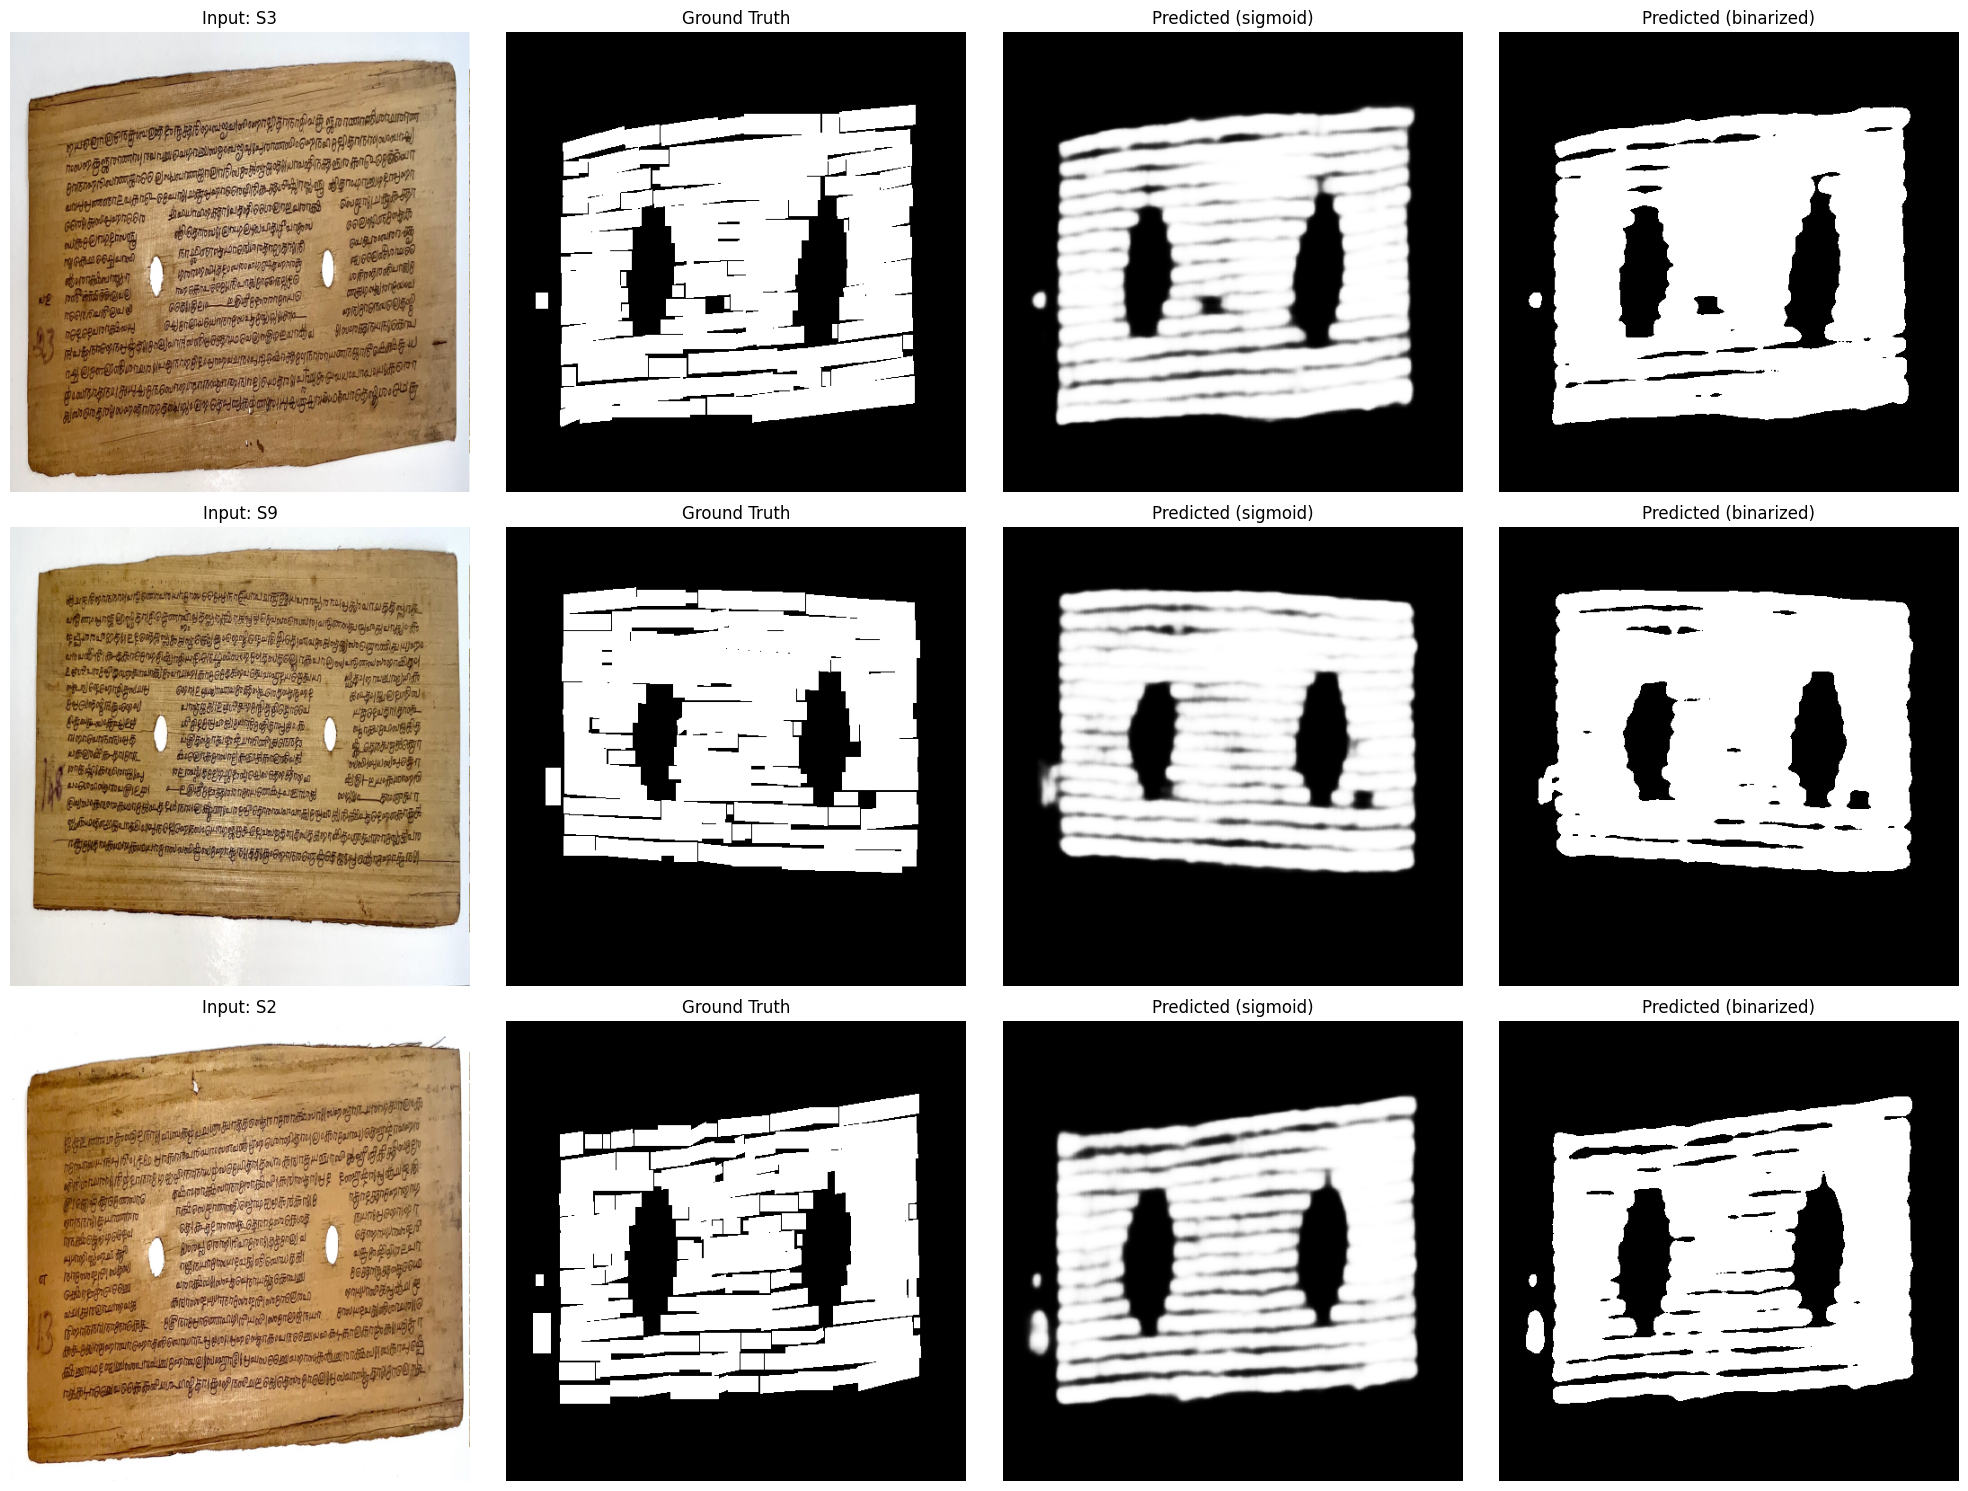

[INFO] Saved visualization to: /content/artifacts/sample_results.png


In [41]:

# ==================== VISUALIZE SAMPLE PREDICTIONS ====================
model.eval()
num_samples = 3
# pick from train_ds (it's a Subset), map indices to underlying dataset
if len(train_ds) < num_samples:
    chosen = list(range(len(train_ds)))
else:
    chosen = random.sample(range(len(train_ds)), num_samples)


plt.figure(figsize=(20, 5 * len(chosen)))
for i, idx in enumerate(chosen):
    img_t, mask_t, name = train_ds[idx]  # train_ds is a Subset returning (img,mask,basename)
    with torch.no_grad():
        pred_logit = model(img_t.unsqueeze(0).to(device))
        pred = torch.sigmoid(pred_logit.cpu()).squeeze().numpy()  # H x W

    binary = (pred > 0.5).astype(np.uint8)
    img_np = img_t.permute(1, 2, 0).numpy()
    mask_np = mask_t.squeeze(0).numpy()

    # input
    plt.subplot(len(chosen), 4, i*4 + 1)
    plt.imshow(img_np)
    plt.title(f"Input: {name}")
    plt.axis("off")

    # ground truth
    plt.subplot(len(chosen), 4, i*4 + 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    # predicted
    plt.subplot(len(chosen), 4, i*4 + 3)
    plt.imshow(pred, cmap="gray")
    plt.title("Predicted (sigmoid)")
    plt.axis("off")

    #binarized
    plt.subplot(len(chosen), 4, i*4 + 4)
    plt.imshow(binary, cmap="gray")
    plt.title("Predicted (binarized)")
    plt.axis("off")

plt.tight_layout()
save_path = os.path.join(ARTIFACT_PATH, "sample_results.png")
plt.savefig(save_path, dpi=150)
plt.show()
print("[INFO] Saved visualization to:", save_path)

In [42]:
# ==================== EVALUATION LOOP FOR RESNET ====================
model.eval()
metrics_sum = {"IoU":0, "Dice":0, "Precision":0, "Recall":0, "Accuracy":0}
count = 0

with torch.no_grad():
    for imgs, masks, _ in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy()   # (B,1,H,W)
        masks_np = masks.cpu().numpy()

        batch_size = probs.shape[0]
        for i in range(batch_size):
            pred = probs[i,0]        # (H,W)
            true = masks_np[i,0]     # (H,W)

            m = compute_metrics(pred, true)
            for k in metrics_sum.keys():
                metrics_sum[k] += m[k]
            count += 1

# average metrics
final_metrics = {k: metrics_sum[k] / count for k in metrics_sum}

print("\n====== Model Evaluation Metrics ======")
for k,v in final_metrics.items():
    print(f"{k}: {v:.4f}")


====== Model Evaluation Metrics ======
IoU: 0.9046
Dice: 0.9499
Precision: 0.9393
Recall: 0.9608
Accuracy: 0.9584


In [ ]:
# SINGLE SAMPLE TESTING
TEST_IMAGE_PATH = "/content/unseen.png"
IMG_SIZE = 512

img = np.array(Image.open(TEST_IMAGE_PATH).convert("RGB"))
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

inp = img_resized.astype(np.float32) / 255.0
inp = torch.tensor(inp).permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(inp)
    prob = torch.sigmoid(logits).cpu().squeeze().numpy()

mask_pred = (prob > 0.5).astype(np.uint8) * 255

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_resized)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(prob, cmap="gray")
plt.title("Predicted Probability Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mask_pred, cmap="gray")
plt.title("Binary Mask (0/1)")
plt.axis("off")

plt.show()

print("Inference complete.")